##  GR DUSP1 Gating Notebook

The Purpose of this notebook is:
1) Load in all analyisis for final dataframe preparation 
2) Filter DUSP1 data to remove partial cells and low SNR spots
3) Filter GR data to remove partial cells
4) Estimate GR cytoplasmic area from DUPS1 data
5) GR intensity to molecular counts 
6) Concatonate final GR and DUSP1 dataframes

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask.array as da
import os
import sys
import logging
import seaborn as sns

logging.getLogger('matplotlib.font_manager').disabled = True
numba_logger = logging.getLogger('numba')
numba_logger.setLevel(logging.WARNING)

matplotlib_logger = logging.getLogger('matplotlib')
matplotlib_logger.setLevel(logging.WARNING)

src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
print(src_path)
sys.path.append(src_path)

from src.Analysis import AnalysisManager, Analysis, SpotDetection_SNRConfirmation, Spot_Cluster_Analysis_WeightedSNR, GR_Confirmation

/Users/ericron/Desktop/AngelFISH


In [ ]:
loc = None 
log_location = r'/Volumes/share/Users/Eric/GR_DUSP1_2025'  # r'/Volumes/share/Users/Jack/All_Analysis' 

In [ ]:
# Measure function to create final DUSP1 dataframe for SSIT
# Function to get the second largest value or default to 0
def second_largest(series):
    unique_vals = series.dropna().unique()  # Remove NaN and get unique values
    if len(unique_vals) < 2:
        return 0  # Return 0 if there's no second-largest value
    return np.sort(unique_vals)[-2]  # Return the second-largest value

def filter_DUSP1(name, is_tpl = False):
    # Initiate the class and find analysis at log_location
    am = AnalysisManager(location=loc, log_location=log_location, mac=True)
    # Select the dataset - DUSP1 100nM Dex 3hr Time-sweep Replica 2
    am.select_analysis(name)
    # Initiate the Weighted SNR analysis class
    SD = Spot_Cluster_Analysis_WeightedSNR(am)
    # Load the data
    SD.get_data()
    # Assign revise weighted threshold
    SD.assign_revised_weighted_threshold()
    # Create unique cell id for every cell
    SD.cellprops['unique_cell_id'] = np.arange(len(SD.cellprops))
    # Remove partial cells from dataset
    SD.cellprops = SD.cellprops[SD.cellprops['touching_border'] == 0]
    # Remove spots that are less than the weighted snr threshold
    SD.spots = SD.spots[SD.spots['keep_wsnr']]
    # Merge the spots and clusters dataframes by the unique cell ID
    SD.spots = SD.spots.merge(SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
                                on=['NAS_location', 'cell_label', 'fov'], 
                                how='left')
    SD.clusters = SD.clusters.merge(SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
                                on=['NAS_location', 'cell_label', 'fov'], 
                                how='left')
    
    SD.display_gating()
    
    am.close()
    # Use measure_DUSP1 to create SSIT compatible dataframe
    if not is_tpl:
        return measure_DUSP1(SD.spots, SD.clusters, SD.cellprops)
    else:
        return measure_DUSP1_TPL(SD.spots, SD.clusters, SD.cellprops)

def filter_GR(name):
    # Initiate the class and find analysis at log_location
    am = AnalysisManager(location=loc, log_location=log_location, mac=True)
    # Select the dataset
    am.select_analysis(name)
    # select GR conformation analysis 
    GR = GR_Confirmation(am)
    # Load the data
    GR.get_data()
    # Create unique cell id for every cell
    GR.cellprops['unique_cell_id'] = np.arange(len(GR.cellprops))
    # Remove partial cells from dataset
    GR.cellprops = GR.cellprops[GR.cellprops['touching_border'] == 0]
    am.close()
    # Use measure_GR to create SSIT compatible dataframe
    return measure_GR(GR.cellprops)

def measure_DUSP1(spots, clusters, props) -> pd.DataFrame:
    results = pd.DataFrame(columns=['cell_id', 'num_ts', 'num_spots_ts', 'largest_ts', 'second_largest_ts', 'num_foci', 'num_spots_foci', 'num_spots', 'num_nuc_spots', 'num_cyto_spots', 
                                    'nuc_area_px', 'cyto_area_px', 'avg_nuc_int', 'avg_cyto_int', 'time', 'Dex_conc', 'replica'])
    
    # Sort spots, clusters, and props by unique_cell_id
    spots = spots.sort_values(by='unique_cell_id')
    clusters = clusters.sort_values(by='unique_cell_id')
    props = props.sort_values(by='unique_cell_id')

    # unique cell id
    cell_ids = props['unique_cell_id']

    # num of ts
    num_ts = clusters[clusters['is_nuc'] == 1].groupby('unique_cell_id').size().reindex(cell_ids, fill_value=0)

    # num of foci
    num_foci = clusters[clusters['is_nuc'] == 0].groupby('unique_cell_id').size().reindex(cell_ids, fill_value=0)

    # num of ts spots
    num_spots_ts = clusters[clusters['is_nuc'] == 1].groupby('unique_cell_id')['nb_spots'].sum().reindex(cell_ids, fill_value=0)

    # largest TS size
    largest_ts = clusters[clusters['is_nuc'] == 1].groupby('unique_cell_id')['nb_spots'].max().reindex(cell_ids, fill_value=0)

    # Compute second-largest TS size per cell
    second_largest_ts = (clusters[clusters['is_nuc'] == 1].groupby('unique_cell_id')['nb_spots'].apply(second_largest).reindex(cell_ids, fill_value=0))    

    # num of foci spots
    num_spots_foci = clusters[clusters['is_nuc'] == 0].groupby('unique_cell_id')['nb_spots'].sum().reindex(cell_ids, fill_value=0)

    # num of spots
    num_spots = spots.groupby('unique_cell_id').size().reindex(cell_ids, fill_value=0)

    # num of spot in nuc
    num_nuc_spots = spots[spots['is_nuc'] == 1].groupby('unique_cell_id').size().reindex(cell_ids, fill_value=0)

    # num of spot in cyto 
    num_cyto_spots = spots[spots['is_nuc'] == 0].groupby('unique_cell_id').size().reindex(cell_ids, fill_value=0)

    # nuc area
    nuc_area = props['nuc_area']

    # cyto area
    cyto_area = props['cyto_area']

    # avg int nuc
    avg_nuc_int = props['nuc_intensity_mean-0']
    
    # avg int cyto
    avg_cyto_int = props['cyto_intensity_mean-0']

    # time (experiment)
    time = props['time'] 

    # Dex conc
    dex_conc = props['Dex_Conc']

    # Replica
    replica = spots.groupby('unique_cell_id')['replica'].first().reindex(cell_ids, fill_value=np.nan)

    results['cell_id'] = cell_ids
    results['num_ts'] = num_ts.values
    results['largest_ts'] = largest_ts.values
    results['second_largest_ts'] = second_largest_ts.values
    results['num_foci'] = num_foci.values
    results['num_spots_ts'] = num_spots_ts.values
    results['num_spots_foci'] = num_spots_foci.values
    results['num_spots'] = num_spots.values
    results['num_nuc_spots'] = num_nuc_spots.values
    results['num_cyto_spots'] = num_cyto_spots.values
    results['nuc_area_px'] = nuc_area.values
    results['cyto_area_px'] = cyto_area.values
    results['avg_nuc_int'] = avg_nuc_int.values
    results['avg_cyto_int'] = avg_cyto_int.values
    results['time'] = time.values
    results['Dex_conc'] = dex_conc.values
    results['replica'] = replica.values

    return results

def measure_DUSP1_TPL(spots, clusters, props) -> pd.DataFrame:
    results = pd.DataFrame(columns=['cell_id', 'num_ts', 'num_spots_ts', 'largest_ts', 'second_largest_ts', 'num_foci', 'num_spots_foci', 'num_spots', 'num_nuc_spots', 'num_cyto_spots', 
                                    'nuc_area_px', 'cyto_area_px', 'avg_nuc_int', 'avg_cyto_int', 'time', 'time_tpl' 'Dex_conc', 'replica',
                                    'tryptCond1', 'tryptCond2', 'tryptCond3', 'tryptCond4', 'tryptCond5'])
    
    # Sort spots, clusters, and props by unique_cell_id
    spots = spots.sort_values(by='unique_cell_id')
    clusters = clusters.sort_values(by='unique_cell_id')
    props = props.sort_values(by='unique_cell_id')

    # unique cell id
    cell_ids = props['unique_cell_id']

    # num of ts
    num_ts = clusters[clusters['is_nuc'] == 1].groupby('unique_cell_id').size().reindex(cell_ids, fill_value=0)

    # num of foci
    num_foci = clusters[clusters['is_nuc'] == 0].groupby('unique_cell_id').size().reindex(cell_ids, fill_value=0)

    # num of ts spots
    num_spots_ts = clusters[clusters['is_nuc'] == 1].groupby('unique_cell_id')['nb_spots'].sum().reindex(cell_ids, fill_value=0)

    # largest TS size
    largest_ts = clusters[clusters['is_nuc'] == 1].groupby('unique_cell_id')['nb_spots'].max().reindex(cell_ids, fill_value=0)

    # Compute second-largest TS size per cell
    second_largest_ts = (clusters[clusters['is_nuc'] == 1].groupby('unique_cell_id')['nb_spots'].apply(second_largest).reindex(cell_ids, fill_value=0))    

    # num of foci spots
    num_spots_foci = clusters[clusters['is_nuc'] == 0].groupby('unique_cell_id')['nb_spots'].sum().reindex(cell_ids, fill_value=0)

    # num of spots
    num_spots = spots.groupby('unique_cell_id').size().reindex(cell_ids, fill_value=0)

    # num of spot in nuc
    num_nuc_spots = spots[spots['is_nuc'] == 1].groupby('unique_cell_id').size().reindex(cell_ids, fill_value=0)

    # num of spot in cyto 
    num_cyto_spots = spots[spots['is_nuc'] == 0].groupby('unique_cell_id').size().reindex(cell_ids, fill_value=0)

    # nuc area
    nuc_area = props['nuc_area']

    # cyto area
    cyto_area = props['cyto_area']

    # avg int nuc
    avg_nuc_int = props['nuc_intensity_mean-0']
    
    # avg int cyto
    avg_cyto_int = props['cyto_intensity_mean-0']

    # time of Dex(experiment)
    time = props['time'] 

    # time of tpl
    time_tpl = props['time_tpl']

    # Dex conc
    dex_conc = props['Dex_Conc']

    # Replica
    replica = spots.groupby('unique_cell_id')['replica'].first().reindex(cell_ids, fill_value=np.nan)

    # Extract unique TPL times
    trptTimes = np.sort(props['time_tpl'].dropna().unique())
    
    # Initialize tryptCond columns
    for k, t_TPL in enumerate(trptTimes, start=1):
        JJ = (
            ((dex_conc == 100) | (time == 0)) &
            ((time == 0) | ((time <= t_TPL) & time_tpl.isna()) | ((time >= t_TPL) & (time_tpl == t_TPL)))
        )
        results[f'tryptCond{k}'] = JJ.astype(int) * k
    
    # Populate DataFrame
    results['cell_id'] = cell_ids
    results['num_ts'] = num_ts.values
    results['largest_ts'] = largest_ts.values
    results['second_largest_ts'] = second_largest_ts.values
    results['num_foci'] = num_foci.values
    results['num_spots_ts'] = num_spots_ts.values
    results['num_spots_foci'] = num_spots_foci.values
    results['num_spots'] = num_spots.values
    results['num_nuc_spots'] = num_nuc_spots.values
    results['num_cyto_spots'] = num_cyto_spots.values
    results['nuc_area_px'] = nuc_area.values
    results['cyto_area_px'] = cyto_area.values
    results['avg_nuc_int'] = avg_nuc_int.values
    results['avg_cyto_int'] = avg_cyto_int.values
    results['time'] = time.values
    results['time_tpl'] = time_tpl.values
    results['Dex_conc'] = dex_conc.values
    results['replica'] = replica.values

    return results

# Measure function for GR pre-SSIT dataframe 
def measure_GR(cellprops) -> pd.DataFrame:
    results = pd.DataFrame(columns=['cell_id', 'nuc_area', 'nucGRint', 'cytoGRint', 'time', 'Dex_conc', 'replica'])
    
    # Sort cellprops by unique_cell_id
    props = cellprops.sort_values(by='unique_cell_id')

    # unique cell id
    cell_ids = props['unique_cell_id']

    # nuc area
    nuc_area = props['nuc_area']

    # avg int nuc
    nucGRint = props['nuc_intensity_mean-0']
    
    # avg int pseudocyto mask
    cytoGRint = props['cyto_intensity_mean-0']

    # time (experiment)
    time = props['time'] 

    # Dex conc
    dex_conc = props['Dex_Conc']

    # Replica
    replica = props['replica']

    results['cell_id'] = cell_ids
    results['nuc_area'] = nuc_area.values
    results['nucGRint'] = nucGRint.values
    results['cytoGRint'] = cytoGRint.values
    results['time'] = time.values
    results['Dex_conc'] = dex_conc.values
    results['replica'] = replica.values

    return results    

# Use the log file to search for analyses

In [ ]:
am = AnalysisManager(location=loc, log_location=log_location, mac=True) 

In [4]:
# list all analysis done 
all_analysis_names = am.list_analysis_names()

Analysis_DUSP1_K_ERonReRun_2025-02-08
Analysis_DUSP1_P_ERonReRun_2025-02-08
Analysis_DUSP1_L_JacksRunAll_2025-02-06
Analysis_DUSP1_I_JacksRunAll_2025-02-06
Analysis_DUSP1_G_ERonReRun_2025-02-08
Analysis_DUSP1_N_JacksRunAll_2025-02-06
Analysis_GR_IC_C_ER020725_2025-02-08
Analysis_DUSP1_O_TPL_2025-02-05
Analysis_DUSP1_M_ERonRunAll_2025-02-06
Analysis_DUSP1_F_ERonReRun_2025-02-08
Analysis_DUSP1_I_Jan2725_2025-01-27
Analysis_DUSP1_G_JacksRunAll_2025-02-06
Analysis_DUSP1_D_JacksRunAll_2025-02-05
Analysis_DUSP1_FinalData_013125_2025-02-02
Analysis_DUSP1_O_JacksRunAll_2025-02-06
Analysis_DUSP1_H_ERonRunAll_2025-02-06
Analysis_GR_IC_A_ER020725_2025-02-07
Analysis_DUSP1_F_JacksRunAll_2025-02-06
Analysis_DUSP1_K_JacksRunAll_2025-02-06
Analysis_GR_IC_B_ReRun021025_2025-02-10
Analysis_DUSP1_E_ERonRunAll_2025-02-06
Analysis_DUSP1_FinalData_013125_2025-02-01
Analysis_DUSP1_J_ERonRunAll_2025-02-06
Analysis_DUSP1_P_TPL_2025-02-05


# DUSP1 Experiment Analysis List

### DUSP1 100nM Dex 3hr Time-sweep
- Replica D: `Analysis_DUSP1_D_JacksRunAll_2025-02-05`
- Replica E: `Analysis_DUSP1_E_ERonRunAll_2025-02-06`
- Replica F: `Analysis_DUSP1_F_ERonReRun_2025-02-08`
- Replica M: `Analysis_DUSP1_M_ERonRunAll_2025-02-06`
- Replica N: `Analysis_DUSP1_N_JacksRunAll_2025-02-06`

### DUSP1 75min Concentration-sweep
- Replica G: `Analysis_DUSP1_G_ERonReRun_2025-02-08`
- Replica H: `Analysis_DUSP1_H_ERonRunAll_2025-02-06`
- Replica I: `Analysis_DUSP1_I_JacksRunAll_2025-02-06`

### DUSP1 0.3, 1, 10nM Dex 3hr Time-sweep
- Replica J: `Analysis_DUSP1_J_ERonRunAll_2025-02-06`
- Replica K: `Analysis_DUSP1_K_ERonReRun_2025-02-08`
- Replica L: `Analysis_DUSP1_L_JacksRunAll_2025-02-06`

### DUSP1 TPL
- Replica O `Analysis_DUSP1_O_JacksRunAll_2025-02-06`
- Replica P `Analysis_DUSP1_P_ERonReRun_2025-02-08`

# GR Experiment Analyis List

### GR 1, 10, 100nM Dex 3hr Time-Sweep
- Replica A: `Analysis_GR_IC_A_ER020725_2025-02-07`
- Replica B: `Analysis_GR_IC_B_ReRun021025_2025-02-10`
- Replica C: `Analysis_GR_IC_C_ER020725_2025-02-08`

## Example workflow

In [5]:
# Initiate the class and find analysis at log_location
# Select the specific analysis - ex. DUSP1 100nM Dex 3hr Time-sweep Replica 1
am.select_analysis('DUSP1_D_JacksRunAll')
print('locations with this dataset:', am.location)

locations with this dataset: ['/Volumes/share/smFISH_images/Eric_smFISH_images/20220304/DUSP1_Dex_75min_20220224.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20220225/DUSP1_Dex_0min_20220224.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20220305/DUSP1_Dex_120min_20220224.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20220305/DUSP1_Dex_90min_20220224.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20220305/DUSP1_Dex_150min_20220224.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20220304/DUSP1_Dex_60min_20220224.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20220303/DUSP1_Dex_40min_20220224.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20220305/DUSP1_Dex_180min_20220224.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20220303/DUSP1_Dex_50min_20220224.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20220225/DUSP1_Dex_30min_20220224.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20220225/DUSP1_Dex_20min_20220224.h5', 

In [6]:
# Initiate the Weighted SNR analysis class
SD = Spot_Cluster_Analysis_WeightedSNR(am)
# Load the data
SD.get_data()
# Assign revise weighted threshold
SD.assign_revised_weighted_threshold()

np.float64(2.823703393278696)

## Filter DUPS1 data to remove partial cells and low SNR spots

In [7]:
# Create unique cell id for every cell
SD.cellprops['unique_cell_id'] = np.arange(len(SD.cellprops))

# Remove partial cells from dataset
SD.cellprops = SD.cellprops[SD.cellprops['touching_border'] == 0]

# Remove spots that are less than the weighted snr threshold
SD.spots = SD.spots[SD.spots['keep_wsnr']]

# Merge the spots and clusters dataframes by the unique cell ID
SD.spots = SD.spots.merge(SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
                            on=['NAS_location', 'cell_label', 'fov'], 
                            how='left')
SD.clusters = SD.clusters.merge(SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
                            on=['NAS_location', 'cell_label', 'fov'], 
                            how='left')

In [8]:
# Use measure_DUSP1 to create SSIT compatible dataframe
DUSP1_RepD = measure_DUSP1(SD.spots, SD.clusters, SD.cellprops)
am.close()

    DUSP1 100nM Dex 3hr Time-sweep Replica 2

In [ ]:
DUSP1_RepE = filter_DUSP1('DUSP1_E_ERonRunAll')

    DUSP1 100nM Dex 3hr Time-sweep Replica 3

In [ ]:
DUSP1_RepF = filter_DUSP1('DUSP1_F_ERonReRun')                        

    DUSP1 100nM Dex 3hr Time-sweep Replica 4 (partial)

In [ ]:
DUSP1_RepM = filter_DUSP1('DUSP1_M_ERonRunAll')                        

    DUSP1 100nM Dex 3hr Time-sweep Replica 5 (partial)

In [ ]:
DUSP1_RepN = filter_DUSP1('DUSP1_N_JacksRunAll')

    DUSP1 75min Concentration-sweep Replica 1

In [ ]:
DUSP1_RepG = filter_DUSP1('DUSP1_G_ERonReRun')                        

    DUSP1 75min Concentration-sweep Replica 2

In [ ]:
DUSP1_RepH = filter_DUSP1('DUSP1_H_ERonRunAll')                         

    DUSP1 75min Concentration-sweep Replica 3

In [ ]:
DUSP1_RepI = filter_DUSP1('DUSP1_I_JacksRunAll')

    DUSP1 0.3, 1, 10nM Dex 3hr Time-sweep Replica 1

In [ ]:
DUSP1_RepJ = filter_DUSP1('DUSP1_J_ERonRunAll')


    DUSP1 0.3, 1, 10nM Dex 3hr Time-sweep Replica 2

In [ ]:
DUSP1_RepK = filter_DUSP1('DUSP1_K_ERonReRun')

    DUSP1 0.3, 1, 10nM Dex 3hr Time-sweep Replica 3

In [ ]:
DUSP1_RepL = filter_DUSP1('DUSP1_L_JacksRunAll')

    DUSP1 100nM Dex & 5µM TPL Time-sweep Replica 1

In [ ]:
DUSP1_RepO_TPL = filter_DUSP1('DUSP1_O_JacksRunAll', True)

    DUSP1 100nM Dex & 5µM TPL Time-sweep Replica 2

In [ ]:
DUSP1_RepP_TPL = filter_DUSP1('DUSP1_P_ERonReRun', True)

In [21]:
# Concatonate all DUSP1 Dex experiments & reset 'unique_cell_id'
DUSP1_ALL = pd.concat(
[DUSP1_RepD, DUSP1_RepE, DUSP1_RepF, DUSP1_RepM, DUSP1_RepN, DUSP1_RepG, DUSP1_RepH, DUSP1_RepI, DUSP1_RepJ, DUSP1_RepK, DUSP1_RepL], ignore_index=True) # 
DUSP1_ALL['unique_cell_id'] = np.arange(len(DUSP1_ALL))

### Filter GR data:
1. Remove partial cells
2. Use `measure_GR` to prepare pre-SSIT dataframe

    GR 1, 10, 100nM Dex 3hr Time-sweep Replica 1

In [ ]:
GR_RepA = filter_GR('GR_IC_A_ER020725')


    GR 1, 10, 100nM Dex 3hr Time-sweep Replica 2

In [ ]:
GR_RepB = filter_GR('GR_IC_B_ReRun021025')

    GR 1, 10, 100nM Dex 3hr Time-sweep Replica 3

In [ ]:
GR_RepC = filter_GR('GR_IC_C_ER020725')

In [25]:
# Concatonate all DUSP1 Dex experiments & reset 'unique_cell_id'
GR_ALL = pd.concat(
[GR_RepA, GR_RepB, GR_RepC], ignore_index=True) # DUSP1_RepN, DUSP1_RepJ
GR_ALL['unique_cell_id'] = np.arange(len(GR_ALL))

In [26]:
GR_ALL

,cell_id,nuc_area,nucGRint,cytoGRint,time,Dex_conc,replica,unique_cell_id
0,0,5281.0,4107.575917,1458.351175,90,10,A,0
1,1,1185.0,4540.710137,1441.959556,90,10,A,1
2,2,8084.0,5442.916579,1504.375279,90,10,A,2
3,3,8027.0,6004.195356,1510.456026,90,10,A,3
4,4,9707.0,5299.208904,1546.691832,90,10,A,4
...,...,...,...,...,...,...,...,...
19221,5601,6167.0,3313.792397,1114.525882,120,10,C,19221
19222,5602,6750.0,2673.532505,1108.000027,120,10,C,19222
19223,5603,9728.0,3704.099971,1136.145253,120,10,C,19223
19224,5604,5593.0,3306.069900,1172.101178,120,10,C,19224


## GR_ALL & DUSP1_All final dataframe preperation for SSIT

1) Fit a Polynomial (2nd-degree) using (nuc_area_px, cyto_area_px) from DUSP1_ALL.

2) Estimate Cytoplasm Area in GR_ALL:
3) Creates `CalcCytoArea` by evaluating the fitted polynomial at each row’s `nuc_area`.

4) Gate both data sets on the 25%–75% range of nuclear area.

5) Compute “Normalized” GR (`normGRnuc`, `normGRcyt`) in GR_ALL:
- Scales nuclear/cyt intensities (5%→95% range) into integer bins [0,20].

6) Plot Histograms for the normalized nuclear/cyt GR (using custom colors).

7) Save the updated, gated data sets to CSV.

DUSP1_ALL original: 46114 rows -> gated: 23059 rows
GR_ALL original:    19226 rows -> gated: 9612 rows


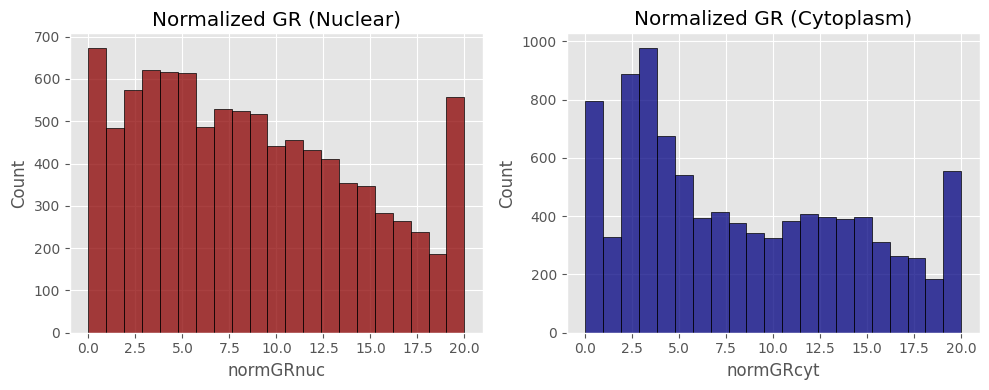

In [ ]:
# 1) READ INPUT DATA
# =========================
# DUSP1_ALL from above:
df_dusp = DUSP1_ALL

# GR_ALL from above:
df_gr = GR_ALL


# 2) FIT POLYNOMIAL TO (NUC, CYTO) FROM DUSP1_ALL
# =========================
# We'll use only the rows that have valid nuc_area_px and cyto_area_px.
df_dusp_nonmissing = df_dusp.dropna(subset=['nuc_area_px', 'cyto_area_px']).copy()

x_nuc = df_dusp_nonmissing['nuc_area_px'].values
y_cyto = df_dusp_nonmissing['cyto_area_px'].values

# Fit a 2nd-degree polynomial: cyto_area_px = a*(nuc_area_px)^2 + b*(nuc_area_px) + c
poly_coeffs = np.polyfit(x_nuc, y_cyto, deg=2)

# optional: for debugging/inspection
# print("Fitted polynomial coefficients (a, b, c):", poly_coeffs)


# 3) ESTIMATE CYTO AREA IN GR_ALL
# =========================
# We'll store the computed cytoplasm area in a new column: 'CalcCytoArea'
# Evaluate the polynomial at GR_ALL['nuc_area'].
df_gr['CalcCytoArea'] = np.polyval(poly_coeffs, df_gr['nuc_area'])



# 4) GATE BOTH DATAFRAMES ON [25%, 75%] NUCLEAR AREA
# =========================
# We'll define a helper function for gating.
def gate_on_nuc_area(df, nuc_col):
    """Return a copy of df gated to [25th, 75th percentile] of nuc_col."""
    lower = df[nuc_col].quantile(0.25)
    upper = df[nuc_col].quantile(0.75)
    return df[(df[nuc_col] >= lower) & (df[nuc_col] <= upper)].copy()

# Gate DUSP1_ALL on nuc_area_px
df_dusp_gated = gate_on_nuc_area(df_dusp, 'nuc_area_px')

# Gate GR_ALL on nuc_area
df_gr_gated = gate_on_nuc_area(df_gr, 'nuc_area')

print(f"DUSP1_ALL original: {len(df_dusp)} rows -> gated: {len(df_dusp_gated)} rows")
print(f"GR_ALL original:    {len(df_gr)} rows -> gated: {len(df_gr_gated)} rows")


# 5) COMPUTE "NORMALIZED" GR FOR NUC & CYTO IN GR_ALL
# =========================
# We'll do a percentile-based normalization: 5th->95th percentile => mapped to [0, bins].
bins = 20

def normalize_by_percentiles(series, low_pct=0.05, high_pct=0.95, bins=20):
    """Scale 'series' into integer bins [0, bins] based on [low_pct, high_pct]."""
    lower_val = series.quantile(low_pct)
    upper_val = series.quantile(high_pct)
    clipped = (series - lower_val) / (upper_val - lower_val)
    clipped = clipped.clip(lower=0, upper=1)
    return (clipped * bins).round().astype(int)

df_gr_gated['normGRnuc'] = normalize_by_percentiles(df_gr_gated['nucGRint'], 0.05, 0.95, bins=bins)
df_gr_gated['normGRcyt'] = normalize_by_percentiles(df_gr_gated['cytoGRint'], 0.05, 0.95, bins=bins)


# 6) HISTOGRAMS
# =========================
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.histplot(df_gr_gated['normGRnuc'], bins=bins+1, color='darkred', edgecolor='black')
plt.title("Normalized GR (Nuclear)")

plt.subplot(1,2,2)
sns.histplot(df_gr_gated['normGRcyt'], bins=bins+1, color='navy', edgecolor='black')
plt.title("Normalized GR (Cytoplasm)")

plt.tight_layout()
plt.show()

In [28]:
# 7) SAVE THE UPDATED GATED DATAFRAMES
# =========================
# Gated DUSP1 (unchanged except row filtering)
df_dusp_gated.to_csv("DUSP1_ALL_gated_V01.csv", index=False)

# Gated GR with new columns: CalcCytoArea, normGRnuc, normGRcyt
df_gr_gated.to_csv("GR_ALL_gated_with_CytoArea_and_normGR_V01.csv", index=False)

print("Saved gated DUSP1 to 'DUSP1_ALL_gated.csv'")
print("Saved gated GR to 'GR_ALL_gated_with_CytoArea_and_normGR.csv'")

Saved gated DUSP1 to 'DUSP1_ALL_gated.csv'
Saved gated GR to 'GR_ALL_gated_with_CytoArea_and_normGR.csv'
